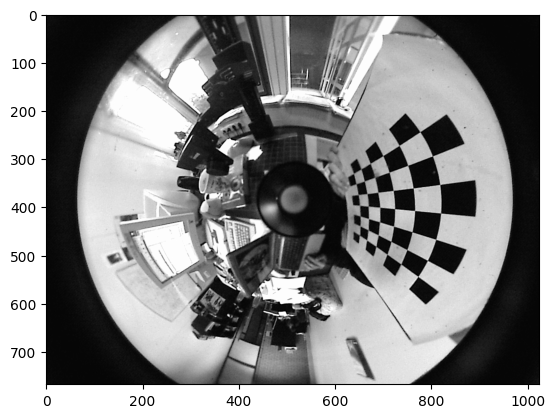

In [21]:
import pathlib
import cv2
from matplotlib import pyplot as plt
import numpy as np

checkboard_size = (7, 4)

def read_images(path: str) -> tuple[list, list]:
    path = pathlib.Path(path)
    images = []
    gray_images = []
    for image_path in path.glob('*.jpg'):
        image = cv2.imread(str(image_path))

        images.append(image)
        # Convert to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray_images.append(gray_image)
    return (images, gray_images)

images, gray_images = read_images('referenceData/OcamCalib')
plt.imshow(gray_images[0], cmap='gray')

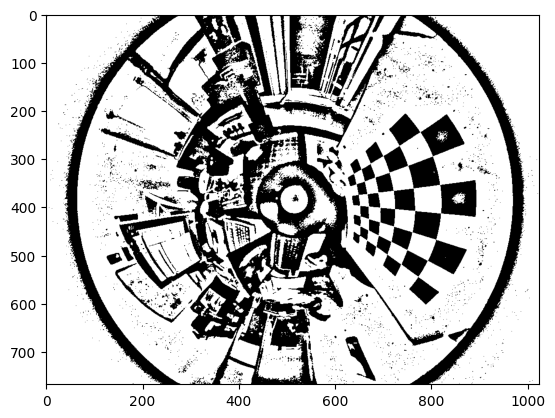

In [22]:
def calculate_adaptive_threshold_kernel_size(img: np.ndarray) -> int:
    # Calculate the kernel size for adaptive thresholding
    # based on the image size
    height, width = img.shape
    kernel_size = int(height * width / 10000)
    if kernel_size % 2 == 0:
        kernel_size += 1
    return kernel_size

binary_images = []
for image in gray_images:
    # Apply thresholding
    kernel_size = calculate_adaptive_threshold_kernel_size(image)
    binary = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, kernel_size, 5)
    binary_images.append(binary)

plt.imshow(binary_images[0], cmap='gray')

In [23]:
def dilate(img: np.ndarray, kernel="rect", iterations=1) -> np.ndarray:
    if kernel == "cross":
        kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
    elif kernel == "rect":
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    elif kernel == "ellipse":
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    else:
        raise ValueError("Unknown kernel type")
    return cv2.dilate(img, kernel, iterations=iterations)

In [24]:
class Quadrangle:
    def __init__(self, points: list[tuple[int, int]]):
        self.points = points
        self.center = self._calculate_center(points)

    def is_similar_to(self, other, epsilon: float) -> bool:
        # Check if the points are similar
        center_1 = self.center
        center_2 = other.center
        center_distance = np.linalg.norm(center_1 - center_2)

        perimeter_1 = self.get_arch_length()
        perimeter_2 = other.get_arch_length()
        perimeter_distance = np.abs(perimeter_1 - perimeter_2)

        return center_distance < epsilon or perimeter_distance < epsilon
        
    def get_arch_length(self) -> float:
        return cv2.arcLength(self.points, True)

    def _calculate_center(self, points):
        center = points.mean(axis=-1).squeeze()
        return center


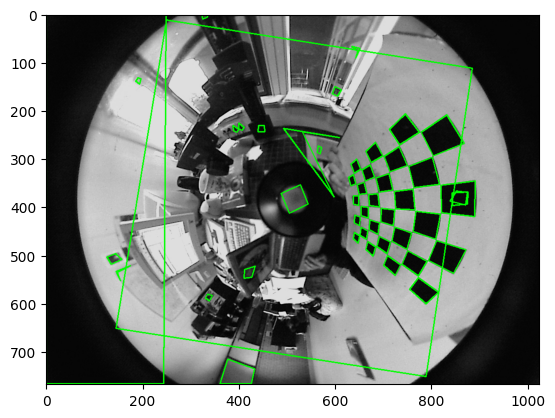

In [25]:
def find_quadrangles(img: np.ndarray, epsilon_ratio=0.1) -> list[Quadrangle]:
    quadrangles = []
    height, width = img.shape
    quadrangle_perimeter_threshold = 2 * (height + width) / 100
    contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        # Approximate the contour with a polygon
        perimeter = cv2.arcLength(contour, True)
        epsilon = epsilon_ratio * perimeter
        approx = cv2.approxPolyDP(contour, epsilon, True)
        # If the polygon has 4 vertices, it is a quadrangle
        approx_perimeter = cv2.arcLength(approx, True)
        if approx_perimeter < quadrangle_perimeter_threshold:
            continue
        if len(approx) == 4:
            quadrangles.append(approx)

    return [Quadrangle(quadrangle) for quadrangle in quadrangles]

def draw_quadrangles(img: np.array, quadrangles: list[Quadrangle]):
    for quadrangle in quadrangles:
        cv2.drawContours(img, [quadrangle.points], 0, (0, 255, 0), 2)
    return img


def remove_similar_quadrangles(quadrangles: list[Quadrangle], old_quadrangles: list[Quadrangle], epsilon: float) -> list[Quadrangle]:
    if len(old_quadrangles) == 0:
        return quadrangles

    new_quadrangles = []
    for quadrangle in quadrangles:
        is_similar = False
        for old_quadangle in old_quadrangles:
            if quadrangle.is_similar_to(old_quadangle, epsilon):
                is_similar = True
                break
        if not is_similar:
            new_quadrangles.append(quadrangle)

    return new_quadrangles

def find_quadrangles_iteratively(img: np.array, max_iterations=1) -> list[Quadrangle]:
    similar_quad_epsilon = 3
    num_checkers = checkboard_size[0] * checkboard_size[1]
    all_quadrangles = []
    prev_quadrangles = []
    for i in range(max_iterations):
        img = dilate(img)
        quadrangles = find_quadrangles(img)
        # compare the similarity with the previous iteration quadrangles, because quadrangles in the previous iteration are already included in the all_quadrangles
        new_quadrangles = remove_similar_quadrangles(
            quadrangles, prev_quadrangles, epsilon=similar_quad_epsilon
        )
        all_quadrangles += new_quadrangles
        prev_quadrangles = quadrangles
    return all_quadrangles

def link_quadrangles(quadrangles):
    # Link quadrangles to form a checkerboard
    # Return links between quadrangles

    for quadrangle in quadrangles:
        for other_quadrangle in quadrangles:
            if quadrangle == other_quadrangle:
                continue            
    
# is_quad_sim = is_quadrangles_similar(np.array([[[1,1]],[[2,2]],[[3,3]],[[5,5]]]), np.array([[[1,1]],[[2,2]],[[3,3]],[[4,4]]]), epsilon=3)
# print(is_quad_sim)
test_image = binary_images[0]
test_original = images[0]
quadrangles = find_quadrangles_iteratively(test_image, max_iterations=5)
test_original = draw_quadrangles(test_original, quadrangles)
plt.imshow(test_original)